# 06 – Real-Life Traffic Video Demo

In this notebook we **apply our trained vehicle classifier** to a **real-life traffic video**.

We will:

- Load the **PyTorch `VehicleClassifier`** model trained in `03_vehicle_classification_model.ipynb`.
- Use **background subtraction** to detect moving vehicles in each frame.
- Classify each detected vehicle into the same classes used in our DETRAC experiments.
- Overlay bounding boxes, labels, confidences, and a simple **traffic density** indicator.
- Save the annotated video(s) under `outputs/videos/`.
- Run visual analytics (time series & distributions) and a brief summary of the results.

This notebook is a **deployment-style demo**, using the model trained earlier rather than training a new one.

#### Imports and project paths

In [1]:
import sys
import os
import time
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# Project root: assuming this notebook lives in a `notebooks/` folder
PROJECT_ROOT = Path().resolve().parent
DATA_ROOT = PROJECT_ROOT / "data"
REAL_LIFE_DATA = DATA_ROOT / "real_life"
MODELS_ROOT = PROJECT_ROOT / "models"
OUTPUT_ROOT = PROJECT_ROOT / "outputs"

# Create needed folders
REAL_LIFE_DATA.mkdir(parents=True, exist_ok=True)
VIDEOS_DIR = OUTPUT_ROOT / "videos"
VIDEOS_DIR.mkdir(parents=True, exist_ok=True)

# Make sure we can import project utilities
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from utils_detrac import VehicleClassifier  # same class as in notebook 03

print("Project root      :", PROJECT_ROOT)
print("Data root         :", DATA_ROOT)
print("Real-life data    :", REAL_LIFE_DATA)
print("Models root       :", MODELS_ROOT)
print("Outputs root      :", OUTPUT_ROOT)
print("Videos output dir :", VIDEOS_DIR)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Project root      : /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3
Data root         : /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data
Real-life data    : /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/real_life
Models root       : /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/models
Outputs root      : /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/outputs
Videos output dir : /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/outputs/videos
Using device: cpu


#### Load trained model and class mapping

We reuse the `VehicleClassifier` model trained in notebook **03** and the class mapping stored in the cropped dataset from notebook **02**.

This ensures the real-life demo is fully consistent with the experimental pipeline.

In [2]:
# Paths to trained model and cropped dataset (from notebooks 02 and 03)
MODEL_PATH = MODELS_ROOT / "vehicle_classifier.pth"
DATASET_NPZ_PATH = DATA_ROOT / "cropped_vehicle_dataset.npz"

if not MODEL_PATH.exists():
    raise FileNotFoundError(
        f"Trained model file not found at: {MODEL_PATH}\n"
        "Please run notebook 03 to train and save the model."
    )

if not DATASET_NPZ_PATH.exists():
    raise FileNotFoundError(
        f"Cropped dataset .npz not found at: {DATASET_NPZ_PATH}\n"
        "Please run notebook 02 to generate and save the dataset."
    )

# Load class mapping from the cropped dataset
npz = np.load(DATASET_NPZ_PATH, allow_pickle=True)
class_to_idx = npz["class_to_idx"].item()
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

print("Classes found:", class_to_idx)
print("Number of classes:", len(class_to_idx))

# Instantiate model and load weights
model = VehicleClassifier(num_classes=len(class_to_idx))
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()

print("Model loaded successfully.")

Classes found: {'car': 0, 'van': 1, 'others': 2, 'bus': 3}
Number of classes: 4
Model loaded successfully.


#### Utility: classify one cropped vehicle

To apply the model to a real-world video, we need two main components:

1. A **preprocessing and classification** function for a cropped vehicle patch.
2. A **background-subtraction–based detector** that finds moving objects and returns bounding boxes.

These pieces are combined later in an end-to-end video processing pipeline.

In [3]:
TARGET_SIZE = (64, 64)  # must match training resolution in notebook 03


def classify_vehicle_crop(model, crop_bgr, device=DEVICE):
    """
    Given a BGR crop from OpenCV, resize and normalize it, then
    run the trained classifier and return (class_name, confidence, idx, probs).
    """
    if crop_bgr is None or crop_bgr.size == 0:
        return None, 0.0, None, None

    # Convert BGR -> RGB, resize, and normalize to [0, 1]
    img_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, TARGET_SIZE)
    img_resized = img_resized.astype("float32") / 255.0

    # HWC -> CHW and add batch dimension
    tensor = torch.from_numpy(img_resized.transpose(2, 0, 1)).unsqueeze(0)

    tensor = tensor.to(device)
    with torch.no_grad():
        logits = model(tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    pred_idx = int(np.argmax(probs))
    pred_class = idx_to_class[pred_idx]
    confidence = float(probs[pred_idx])

    return pred_class, confidence, pred_idx, probs

#### Background subtraction and detection functions

In [4]:
def create_background_subtractor():
    """
    Create a background subtractor for moving-object detection.
    Parameters can be tuned based on the video characteristics.
    """
    return cv2.createBackgroundSubtractorMOG2(
        history=500, varThreshold=50, detectShadows=True
    )


def detect_vehicles_in_frame(frame_bgr, bg_subtractor, min_area=800):
    """
    Apply background subtraction + morphology + contour detection
    to approximate moving vehicles in a frame.

    Returns:
        boxes: list of (x1, y1, x2, y2) in pixel coordinates
        fg_mask: raw foreground mask
        cleaned_mask: mask after thresholding/morphology
    """
    fg_mask = bg_subtractor.apply(frame_bgr)

    # Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    cleaned = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Threshold to obtain a binary mask
    _, thresh = cv2.threshold(cleaned, 200, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    h, w = frame_bgr.shape[:2]
    boxes = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue

        x, y, bw, bh = cv2.boundingRect(cnt)
        x1, y1 = max(0, x), max(0, y)
        x2, y2 = min(w, x + bw), min(h, y + bh)

        # Simple heuristic to ignore extremely thin regions
        if (x2 - x1) < 10 or (y2 - y1) < 10:
            continue

        boxes.append((x1, y1, x2, y2))

    return boxes, fg_mask, thresh


def compute_density_level(count, thresholds=(3, 7)):
    """
    Map a per-frame vehicle count to a simple textual density level.
    thresholds = (low_threshold, high_threshold)
    """
    low, high = thresholds
    if count < low:
        return "Low"
    elif count < high:
        return "Medium"
    else:
        return "High"

#### Debug a Single Frame

Before running the full video, it can be helpful to visualize:

- The raw frame,
- The detected bounding boxes,
- The cleaned foreground mask.

This cell lets us inspect one frame and adjust detection parameters if needed.

In [5]:
def debug_single_frame(input_path, frame_index=0, min_area=800):
    """
    Load a single frame from the real-life video, run the detection pipeline,
    and visualize:
      - the frame with bounding boxes,
      - the foreground mask.
    """
    input_path = Path(input_path)
    if not input_path.exists():
        print(f"Video not found: {input_path}")
        return

    cap = cv2.VideoCapture(str(input_path))
    if not cap.isOpened():
        print(f"Could not open video: {input_path}")
        return

    # Seek to the requested frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame_bgr = cap.read()
    cap.release()

    if not ret:
        print(f"Could not read frame {frame_index} from video.")
        return

    bg_sub = create_background_subtractor()
    # Prime the subtractor slightly
    for _ in range(5):
        bg_sub.apply(frame_bgr)

    boxes, fg_mask, mask_clean = detect_vehicles_in_frame(
        frame_bgr, bg_sub, min_area=min_area
    )

    frame_vis = frame_bgr.copy()
    for (x1, y1, x2, y2) in boxes:
        cv2.rectangle(frame_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

    mask_color = cv2.cvtColor(mask_clean, cv2.COLOR_GRAY2BGR)

    # Convert BGR to RGB for plotting
    frame_vis_rgb = cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB)
    mask_rgb = cv2.cvtColor(mask_color, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(frame_vis_rgb)
    plt.title(f"Frame {frame_index} with detections")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_rgb)
    plt.title("Foreground mask (cleaned)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Example usage (uncomment after placing a real video):
# debug_single_frame(REAL_LIFE_DATA / "traffic_example.mov", frame_index=100, min_area=800)

#### End-to-End Video Processing Pipeline

The main function `process_traffic_video`:

- Opens the input video.
- Detects moving vehicles in each frame.
- Classifies each detected vehicle using our trained model.
- Draws bounding boxes, labels, and a per-frame density indicator.
- Writes three output videos to `outputs/videos/`:
  - Full analysis (detections + labels + overlays),
  - Detections only (boxes),
  - Foreground mask (for debugging).

In [6]:
def process_traffic_video(
    input_path,
    output_dir,
    model,
    idx_to_class,
    device=DEVICE,
    target_size=TARGET_SIZE,
    min_area=800,
    density_thresholds=(3, 7),
):
    """
    Process a traffic video:
      - Detect moving vehicles with background subtraction.
      - Classify each detected vehicle with our PyTorch model.
      - Draw bounding boxes and labels on each frame.
      - Overlay per-frame vehicle count and density level.
      - Save the annotated video(s) under output_dir.

    Returns a results dict with:
        'vehicle_counts'      – list[int]
        'density_levels'      – list[str]
        'classification_log'  – per-frame list of class names
        'output_files'        – dict of video paths
        'processed_frames'    – number of frames processed
        'fps'                 – frames per second of input video
    """
    input_path = Path(input_path)
    if not input_path.exists():
        raise FileNotFoundError(f"Input video not found: {input_path}")

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    cap = cv2.VideoCapture(str(input_path))
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {input_path}")

    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0

    # Read first frame to get reliable width/height
    ret, frame_bgr = cap.read()
    if not ret:
        cap.release()
        raise RuntimeError("Could not read first frame from video.")

    height, width = frame_bgr.shape[:2]
    print(f"Processing video: {input_path.name}")
    print(f"Resolution: {width}x{height}, FPS: {fps:.1f}")

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")

    analysis_path = output_dir / f"{input_path.stem}_analysis.mp4"
    detection_only_path = output_dir / f"{input_path.stem}_detections.mp4"
    mask_path = output_dir / f"{input_path.stem}_mask.mp4"

    writer_analysis = cv2.VideoWriter(str(analysis_path), fourcc, fps, (width, height))
    writer_detections = cv2.VideoWriter(str(detection_only_path), fourcc, fps, (width, height))
    writer_mask = cv2.VideoWriter(str(mask_path), fourcc, fps, (width, height))

    bg_subtractor = create_background_subtractor()

    vehicle_counts = []
    density_levels = []
    classification_log = []

    frame_idx = 0
    start_time = time.time()

    while ret:
        boxes, fg_mask, mask_clean = detect_vehicles_in_frame(
            frame_bgr, bg_subtractor, min_area=min_area
        )

        annotated = frame_bgr.copy()
        detections_only = frame_bgr.copy()
        mask_color = cv2.cvtColor(mask_clean, cv2.COLOR_GRAY2BGR)

        frame_classes = []
        count = 0

        for (x1, y1, x2, y2) in boxes:
            crop_bgr = frame_bgr[y1:y2, x1:x2]
            pred_class, conf, pred_idx, probs = classify_vehicle_crop(
                model, crop_bgr, device=device
            )
            if pred_class is None:
                continue

            count += 1
            frame_classes.append(pred_class)

            # Draw bounding boxes
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.rectangle(detections_only, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Label string
            label = f"{pred_class} {conf:.2f}"
            label_y = max(y1 - 5, 0)
            cv2.putText(
                annotated,
                label,
                (x1, label_y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 0),
                1,
                cv2.LINE_AA,
            )

        density = compute_density_level(count, thresholds=density_thresholds)

        # Overlay per-frame summary text
        overlay_text = f"Frame: {frame_idx} | Vehicles: {count} | Density: {density}"
        cv2.putText(
            annotated,
            overlay_text,
            (10, 25),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 255),
            2,
            cv2.LINE_AA,
        )

        vehicle_counts.append(count)
        density_levels.append(density)
        classification_log.append(frame_classes)

        writer_analysis.write(annotated)
        writer_detections.write(detections_only)
        writer_mask.write(mask_color)

        frame_idx += 1
        ret, frame_bgr = cap.read()  # read next frame

    cap.release()
    writer_analysis.release()
    writer_detections.release()
    writer_mask.release()

    elapsed = time.time() - start_time
    print(f"Done. Processed {frame_idx} frames in {elapsed:.1f} seconds.")

    return {
        "vehicle_counts": vehicle_counts,
        "density_levels": density_levels,
        "classification_log": classification_log,
        "output_files": {
            "analysis": analysis_path,
            "detections": detection_only_path,
            "mask": mask_path,
        },
        "processed_frames": frame_idx,
        "fps": fps,
    }

#### Run the pipeline on a real video

run the pipeline on a real traffic video:

- **Input** video: `data/real_life/traffic_example.mov`
- **Output** videos: written under `outputs/videos/`

In [7]:
# Default path for real-world video
# (Place your file here: data/real_life/traffic_example.mov)
INPUT_VIDEO_PATH = REAL_LIFE_DATA / "traffic_example.mov"

print("Input video path:", INPUT_VIDEO_PATH)

if not INPUT_VIDEO_PATH.exists():
    print(
        "WARNING: Input video file not found.\n"
        "Please place a file named 'traffic_example.mov' inside:\n"
        f"    {REAL_LIFE_DATA}\n\n"
        "Or adjust INPUT_VIDEO_PATH in this cell."
    )
    results = None
else:
    results = process_traffic_video(
        input_path=INPUT_VIDEO_PATH,
        output_dir=VIDEOS_DIR,
        model=model,
        idx_to_class=idx_to_class,
        device=DEVICE,
        target_size=TARGET_SIZE,
        min_area=800,
        density_thresholds=(3, 7),
    )

    print("\nOutput videos written to:")
    for name, path in results["output_files"].items():
        print(f"  {name}: {path}")

Input video path: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/real_life/traffic_example.mov
Processing video: traffic_example.mov
Resolution: 640x372, FPS: 60.0
Done. Processed 1977 frames in 9.7 seconds.

Output videos written to:
  analysis: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/outputs/videos/traffic_example_analysis.mp4
  detections: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/outputs/videos/traffic_example_detections.mp4
  mask: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/outputs/videos/traffic_example_mask.mp4


#### Traffic Analytics and Visualizations

- Plot the estimated number of vehicles over time,
- Visualize traffic density distributions and evolution,
- Summarize basic statistics (e.g., average vehicles per frame).

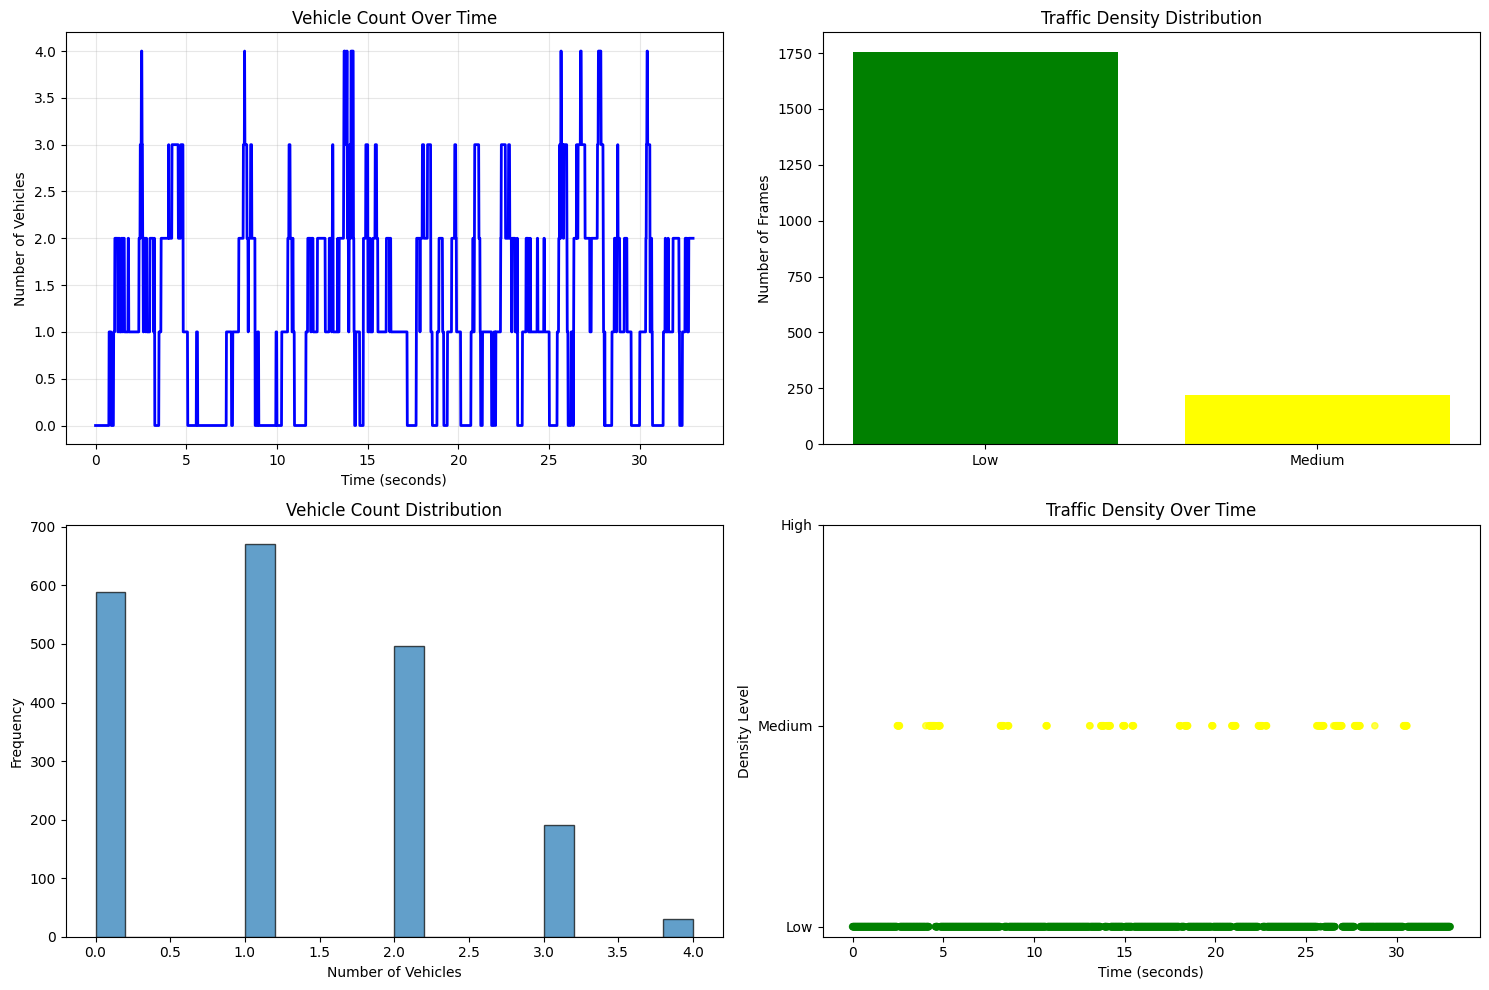


=== TRAFFIC ANALYSIS SUMMARY ===
Total frames processed: 1977
Video duration: 33.0 seconds
Average vehicles per frame: 1.2
Maximum vehicles detected: 4
Minimum vehicles detected: 0

Density Distribution:
  Low: 1755 frames (88.8%)
  Medium: 222 frames (11.2%)

Output Files Generated:
  1. traffic_example_analysis.mp4 (11.9 MB)
  2. traffic_example_detections.mp4 (10.5 MB)
  3. traffic_example_mask.mp4 (9.5 MB)


In [8]:
# Visualize results and analytics
if results is not None:
    vehicle_counts = results["vehicle_counts"]
    density_levels = results["density_levels"]

    if len(vehicle_counts) == 0:
        print("No vehicle counts recorded – nothing to visualize.")
    else:
        # Create analytics plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Time axis in seconds using actual FPS
        fps = results.get("fps", 10.0)
        time_axis = np.arange(len(vehicle_counts)) / fps

        # Plot 1: Vehicle count over time
        axes[0, 0].plot(time_axis, vehicle_counts, "b-", linewidth=2)
        axes[0, 0].set_title("Vehicle Count Over Time")
        axes[0, 0].set_xlabel("Time (seconds)")
        axes[0, 0].set_ylabel("Number of Vehicles")
        axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Density distribution
        density_counts = {}
        for level in density_levels:
            density_counts[level] = density_counts.get(level, 0) + 1

        # Keep color mapping consistent for Low/Medium/High
        bar_labels = list(density_counts.keys())
        bar_colors = []
        for level in bar_labels:
            if level.lower() == "low":
                bar_colors.append("green")
            elif level.lower() == "medium":
                bar_colors.append("yellow")
            else:  # treat anything else as "High"
                bar_colors.append("red")

        axes[0, 1].bar(bar_labels, density_counts.values(), color=bar_colors)
        axes[0, 1].set_title("Traffic Density Distribution")
        axes[0, 1].set_ylabel("Number of Frames")

        # Plot 3: Vehicle count histogram
        axes[1, 0].hist(vehicle_counts, bins=20, alpha=0.7, edgecolor="black")
        axes[1, 0].set_title("Vehicle Count Distribution")
        axes[1, 0].set_xlabel("Number of Vehicles")
        axes[1, 0].set_ylabel("Frequency")

        # Plot 4: Density over time as a scatter
        density_numeric = []
        for level in density_levels:
            if level.lower() == "low":
                density_numeric.append(0)
            elif level.lower() in ("medium", "average"):
                density_numeric.append(1)
            else:  # high
                density_numeric.append(2)

        colors = ["green" if d == 0 else "yellow" if d == 1 else "red" for d in density_numeric]
        axes[1, 1].scatter(time_axis, density_numeric, c=colors, alpha=0.7, s=20)
        axes[1, 1].set_title("Traffic Density Over Time")
        axes[1, 1].set_xlabel("Time (seconds)")
        axes[1, 1].set_ylabel("Density Level")
        axes[1, 1].set_yticks([0, 1, 2])
        axes[1, 1].set_yticklabels(["Low", "Medium", "High"])

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\n=== TRAFFIC ANALYSIS SUMMARY ===")
        total_frames = len(vehicle_counts)
        duration = total_frames / fps if fps > 0 else float("nan")
        print(f"Total frames processed: {total_frames}")
        print(f"Video duration: {duration:.1f} seconds")
        print(f"Average vehicles per frame: {np.mean(vehicle_counts):.1f}")
        print(f"Maximum vehicles detected: {np.max(vehicle_counts)}")
        print(f"Minimum vehicles detected: {np.min(vehicle_counts)}")

        print("\nDensity Distribution:")
        for level, count in density_counts.items():
            percentage = (count / total_frames) * 100
            print(f"  {level}: {count} frames ({percentage:.1f}%)")

        print("\nOutput Files Generated:")
        for i, (name, file_path) in enumerate(results["output_files"].items(), 1):
            file_path = Path(file_path)
            if file_path.exists():
                file_size = file_path.stat().st_size / (1024 * 1024)  # MB
                print(f"  {i}. {file_path.name} ({file_size:.1f} MB)")
            else:
                print(f"  {i}. {file_path.name} (file not found)")
else:
    print("No results to visualize. Please run the video processing cell first.")

#### Predicted class distribution in the real-life video

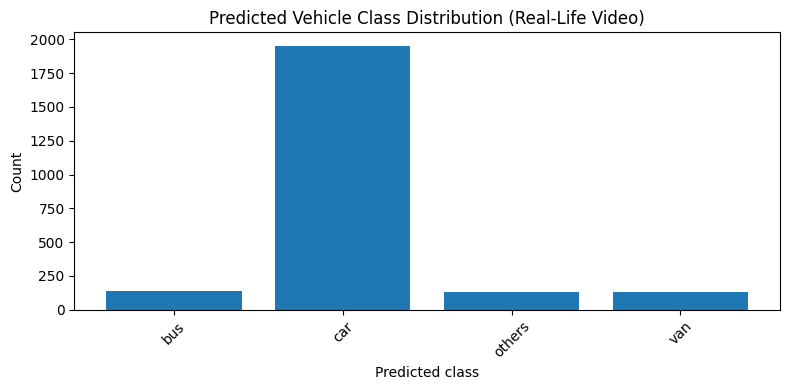

Predicted class counts:
  bus: 140
  car: 1955
  others: 133
  van: 133


In [9]:
if results is not None:
    all_predicted_classes = [
        cls
        for frame_classes in results["classification_log"]
        for cls in frame_classes
    ]

    if len(all_predicted_classes) == 0:
        print("No predicted vehicles to analyze for class distribution.")
    else:
        unique_classes, counts = np.unique(all_predicted_classes, return_counts=True)
        class_counts = dict(zip(unique_classes, counts))

        plt.figure(figsize=(8, 4))
        plt.bar(class_counts.keys(), class_counts.values())
        plt.xlabel("Predicted class")
        plt.ylabel("Count")
        plt.title("Predicted Vehicle Class Distribution (Real-Life Video)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print("Predicted class counts:")
        for cls in sorted(class_counts.keys()):
            print(f"  {cls}: {class_counts[cls]}")
else:
    print("No results to analyze. Please run the video processing cell first.")


#### Preview the generated videos inline

In [10]:
if results is not None:
    from IPython.display import Video, display, HTML

    for name, path in results["output_files"].items():
        if Path(path).exists():
            display(HTML(f"<h3>{name.title()} Video</h3>"))
            display(Video(str(path), width=640, height=480))
        else:
            print(f"Video file not found on disk: {path}")
else:
    print("No videos to display. Please run the processing cell first.")

## Summary and Conclusions

In this notebook, we demonstrated how to **deploy our trained vehicle classifier on a real-life traffic video**:

- We reused the `VehicleClassifier` model trained on the **DETRAC** dataset and the same class mapping from our cropped vehicle dataset.
- Using **background subtraction**, we automatically detected moving vehicles in each frame of a real-world video.
- For each detected region, we:
  - Cropped and resized the patch,
  - Classified it into one of our vehicle classes,
  - Drew bounding boxes and labels with confidence scores.
- We overlaid a simple **traffic density estimate** per frame (Low / Medium / High).
- The resulting annotated videos were saved under:  
  `outputs/videos/`
- We generated **time-series and distribution plots**, summarizing how vehicle counts and density levels evolved over the duration of the video.

This notebook serves as a **bridge between the experimental pipeline (Notebooks 01–05)** and a **practical real-world application**:

- It confirms that our model can be used on real videos, not just on curated DETRAC sequences.
- It also highlights limitations:
  - Background subtraction is sensitive to camera motion and lighting changes.
  - Detection quality directly impacts classification accuracy.

Possible next steps:

- Replace background subtraction with a more robust detector (e.g., YOLO-style model).
- Improve tracking across frames to obtain stable vehicle IDs and trajectories.
- Integrate this pipeline more tightly with the counting and LMV/HMV analytics from  
  `04_vehicle_counting_and_analysis.ipynb`.

For the purposes of this project, this notebook is our **deployment-style demo** and completes the end-to-end story:  
from **dataset exploration** → **training and evaluation** → **real-world inference and analytics**.